In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os


#import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [4]:
%%time
if os.path.isfile('train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Wall time: 1min 15s


In [45]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [46]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [47]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [48]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,424175,1404855,1


In [49]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,783368,1420922,1


In [98]:
if os.path.isfile('storage_sample_stage4.h5'):
    df_train_final=read_hdf('storage_sample_stage4.h5','train_df','r')
    df_test_final=read_hdf('storage_sample_stage4.h5','test_df','r')

In [99]:
df_test_final.shape

(50002, 54)

In [82]:
df_test_final.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [100]:
df_train_final.shape

(100002, 54)

In [51]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [52]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [53]:
%%time
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

KeyboardInterrupt: 

In [54]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [101]:
%%time
df_train_final[['svd_dot_1_s', 'svd_dot_2_s','svd_dot_3_s', 'svd_dot_4_s', 'svd_dot_5_s', 'svd_dot_6_s']]= \
df_train_final.source_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)
df_train_final[['svd_dot_1_d', 'svd_dot_2_d','svd_dot_3_d', 'svd_dot_4_d', 'svd_dot_5_d', 'svd_dot_6_d']]= \
df_train_final.destination_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)

df_test_final[['svd_dot_1_s', 'svd_dot_2_s','svd_dot_3_s', 'svd_dot_4_s', 'svd_dot_5_s', 'svd_dot_6_s']]= \
df_test_final.source_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)
df_test_final[['svd_dot_1_d', 'svd_dot_2_d','svd_dot_3_d', 'svd_dot_4_d', 'svd_dot_5_d', 'svd_dot_6_d']]= \
df_test_final.destination_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)

Wall time: 2h 4min 48s


In [56]:
def prefer_attach_followers(a,b):
    try:
        x=(len(set(train_graph.successors(a)))*len(set(train_graph.successors(b))))
        
        return x
    except:
        return 0

In [57]:
def prefer_attach_followees(a,b):
    try:
        y=(len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b))))
        
        return y
    except:
        return 0

In [102]:
%%time
df_train_final['prefer_attach_followers']=df_train_final.apply(lambda row:
                                                           prefer_attach_followers(row['source_node'],row['destination_node']),axis=1)
df_train_final['prefer_attach_followees']=df_train_final.apply(lambda row:
                                                           prefer_attach_followees(row['source_node'],row['destination_node']),axis=1)

df_test_final['prefer_attach_followers']=df_test_final.apply(lambda row:
                                                           prefer_attach_followers(row['source_node'],row['destination_node']),axis=1)
df_test_final['prefer_attach_followees']=df_test_final.apply(lambda row:
                                                           prefer_attach_followees(row['source_node'],row['destination_node']),axis=1)



hdf=HDFStore('stored_data1.h5')
hdf.put('train_df',df_train_final,format='table',data_columns=True)
hdf.put('test_df',df_test_final,format='table',data_columns=True)
hdf.close()

Wall time: 58.6 s


In [5]:
df_train_final=read_hdf('stored_data1.h5','train_df','r')
df_test_final=read_hdf('stored_data1.h5','test_df','r')

In [3]:
df_train_final.columns


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_1_s', 'svd_dot_2_s', 'svd_dot_3_s', 'svd_dot_4_s',
       'svd_dot_5_s', 'svd_dot_6_s', 'svd_dot_1_d', 'svd_dot_2_d

In [4]:
df_test_final.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_1_s', 'svd_dot_2_s', 'svd_dot_3_s', 'svd_dot_4_s',
       'svd_dot_5_s', 'svd_dot_6_s', 'svd_dot_1_d', 'svd_dot_2_d

In [6]:
y_train = df_train_final.indicator_link
y_test = df_test_final.indicator_link

In [7]:
df_train_final.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_test_final.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [8]:
df_train_final.shape

(100002, 65)

In [9]:
df_test_final.shape

(50002, 65)

In [11]:
y_train.shape

(100002,)

In [12]:
y_test.shape

(50002,)

Estimators =  10 Train Score 0.9129895186942691 test Score 0.9085009733939001
Estimators =  50 Train Score 0.9194720574722245 test Score 0.91511569416499
Estimators =  100 Train Score 0.9216766116643851 test Score 0.9176174496644295
Estimators =  250 Train Score 0.9210369580890881 test Score 0.9164149043303121
Estimators =  450 Train Score 0.9208816462968765 test Score 0.9136082734266616
Wall time: 51 s


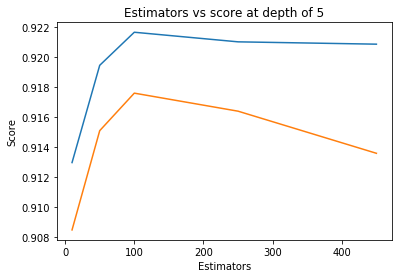

In [13]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_train_final,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train_final))
    test_sc = f1_score(y_test,clf.predict(df_test_final))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

Estimators =  90 Train Score 0.9218438546873858 test Score 0.9179063822654318
Estimators =  95 Train Score 0.9225138554846806 test Score 0.9184380049100866
Estimators =  100 Train Score 0.9216766116643851 test Score 0.9176174496644295
Estimators =  105 Train Score 0.9212170605813638 test Score 0.9172714687250912
Estimators =  110 Train Score 0.921170064899098 test Score 0.9171124677449808
Estimators =  120 Train Score 0.9216225542995179 test Score 0.9174469871929456
Estimators =  125 Train Score 0.9219297419968834 test Score 0.9177043741206611
Wall time: 48.4 s


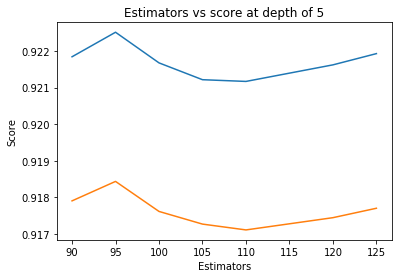

In [15]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
estimators = [90,95,100,105,110,120,125]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_train_final,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train_final))
    test_sc = f1_score(y_test,clf.predict(df_test_final))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8941630847816606 test Score 0.8763504388926401
depth =  9 Train Score 0.9555205627926951 test Score 0.9216597650638046
depth =  11 Train Score 0.9582174404743712 test Score 0.9231936279157975
depth =  15 Train Score 0.9627434205165812 test Score 0.9261144075849398
depth =  20 Train Score 0.9635194006758683 test Score 0.9239360351975633
depth =  35 Train Score 0.9636572731251082 test Score 0.9228684550401219
depth =  50 Train Score 0.9636572731251082 test Score 0.9228684550401219
depth =  70 Train Score 0.9636572731251082 test Score 0.9228684550401219
depth =  130 Train Score 0.9636572731251082 test Score 0.9228684550401219


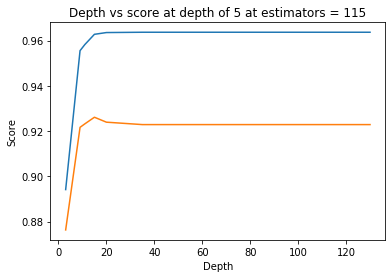

In [14]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_train_final,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train_final))
    test_sc = f1_score(y_test,clf.predict(df_test_final))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

depth =  9 Train Score 0.9555205627926951 test Score 0.9216597650638046
depth =  11 Train Score 0.9582174404743712 test Score 0.9231936279157975
depth =  13 Train Score 0.9620557548092599 test Score 0.9223730752123356
depth =  15 Train Score 0.9627434205165812 test Score 0.9261144075849398
depth =  17 Train Score 0.9631009835664978 test Score 0.9262815777810608
depth =  20 Train Score 0.9635194006758683 test Score 0.9239360351975633


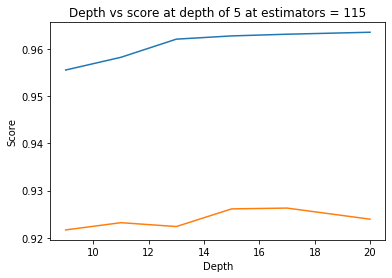

In [16]:
depths = [9,11,13,15,17,20]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_train_final,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train_final))
    test_sc = f1_score(y_test,clf.predict(df_test_final))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [2]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# Applying randomsearch for cross validation

In [25]:
%%time
param_dist={'n_estimators':sp_randint(95,110),'max_depth':sp_randint(12,20),'min_samples_split':sp_randint(110,190),
            'min_samples_leaf':sp_randint(25,65)}
clf=RandomForestClassifier(random_state=23,n_jobs=-1)
cv_search=RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, scoring='f1', n_jobs=-1, 
                             cv=10,random_state=23,return_train_score=True)
cv_search.fit(df_train_final,y_train)
print('mean test scores',cv_search.cv_results_['mean_test_score'])
print('mean train scores',cv_search.cv_results_['mean_train_score'])

mean test scores [0.96129354 0.96114685 0.96189397 0.96256586 0.96156208]
mean train scores [0.96189714 0.96203082 0.96258502 0.96331515 0.96224888]
Wall time: 6min 30s


In [26]:
cv_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=37, min_samples_split=159,
                       min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=-1,
                       oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [27]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=37, min_samples_split=159,
                       min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=-1,
                       oob_score=False, random_state=23, verbose=0,
                       warm_start=False)
clf.fit(df_train_final,y_train)
y_train_predict=clf.predict(df_train_final)
y_test_predict=clf.predict(df_test_final)

In [28]:
print('f1 score of train data is',f1_score(y_train,y_train_predict))
print('f1 score of train data is',f1_score(y_test,y_test_predict))

f1 score of train data is 0.962778048384478
f1 score of train data is 0.925498779358532


# plotting confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix

In [21]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [34]:
print('confusion matrix of y_train',confusion_matrix(y_train,y_train_predict))

confusion matrix of y_train [[48896  1056]
 [ 2612 47438]]


In [35]:
print('confusion matrix of y_test',confusion_matrix(y_test,y_test_predict))

confusion matrix of y_test [[24474   572]
 [ 2968 21988]]


Train confusion_matrix


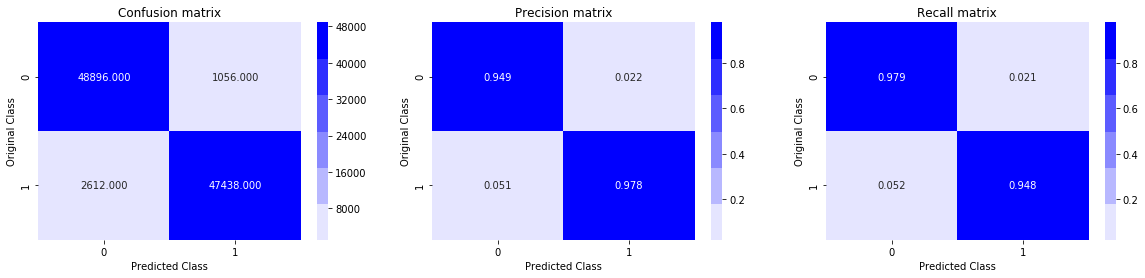

Test confusion_matrix


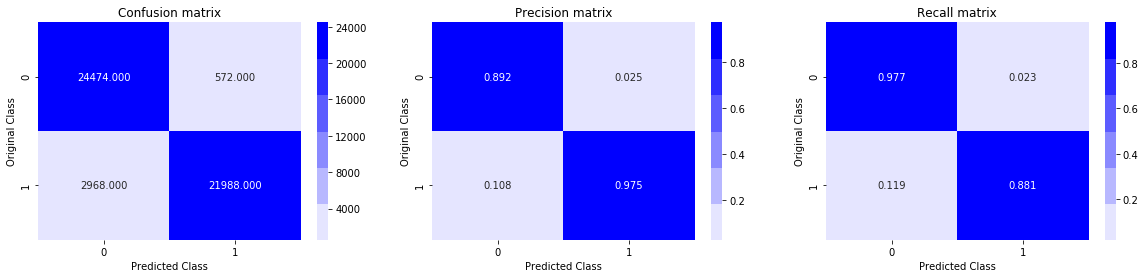

In [37]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_predict)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_predict)

auc score is 0.9633359465646462


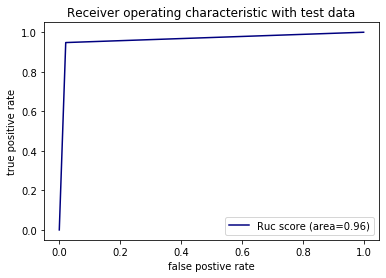

In [41]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,thre=roc_curve(y_train,y_train_predict)
auc_sc=auc(fpr,tpr)

plt.plot(fpr,tpr,color='navy',label='Ruc score (area=%0.2f)'%auc_sc)
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.title('Receiver operating characteristic with test data')

plt.legend()
plt.show
print('auc score is',auc_sc)

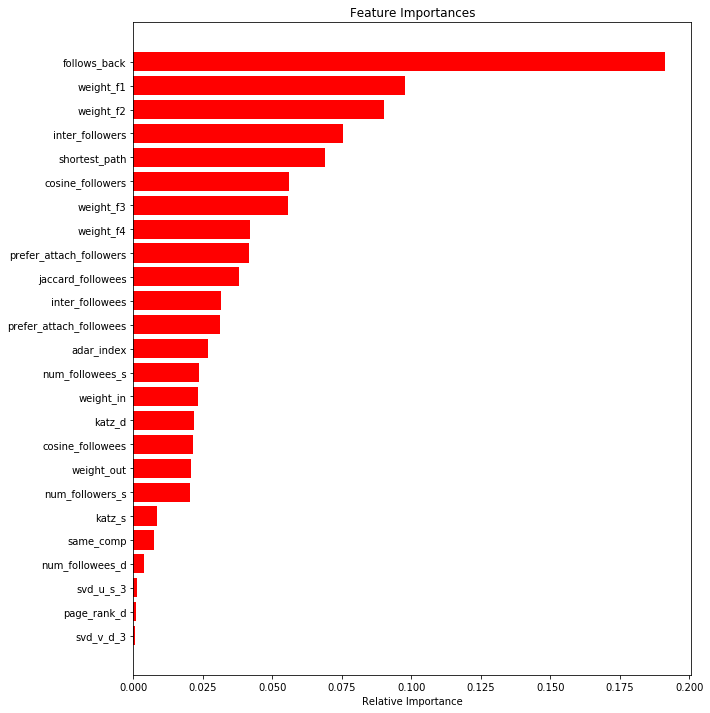

In [45]:
features=df_train_final.columns
imp=clf.feature_importances_
indices = (np.argsort(imp))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# xgboost using xgbclassifier

estimators 10 Train Score 0.929299544719913 test Score 0.9270714012982054
estimators 20 Train Score 0.9601278531328116 test Score 0.9280727734292363
estimators 50 Train Score 0.9716628701594533 test Score 0.9308258312074381
estimators 80 Train Score 0.974612086876324 test Score 0.9294526646033832
estimators 100 Train Score 0.9765112891478513 test Score 0.9294020461333163
estimators 150 Train Score 0.9803921568627452 test Score 0.9291301859193148
estimators 250 Train Score 0.9869524135019401 test Score 0.9258841794092001
estimators 400 Train Score 0.9943698657583651 test Score 0.9156838736009967
estimators 500 Train Score 0.997268825595006 test Score 0.9136891950064572


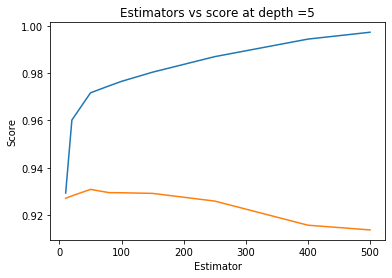

In [50]:
import xgboost 
from xgboost.sklearn import XGBClassifier
est=[10,20,50,80,100,150,250,400,500]
train_scores=[]
test_scores=[]
for i in est:
    clf=XGBClassifier(learning_rate =0.1,n_estimators=i, max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,
                      colsample_bytree=0.8, objective= 'binary:logistic',nthread=-1, scale_pos_weight=1,seed=27)
    clf.fit(df_train_final,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train_final))
    test_sc = f1_score(y_test,clf.predict(df_test_final))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('estimators',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(est,train_scores,label='Train Score')
plt.plot(est,test_scores,label='Test Score')
plt.xlabel('Estimator')
plt.ylabel('Score')
plt.title('Estimators vs score at depth =5')
plt.show()

estimators 2 Train Score 0.9444120087269151 test Score 0.9185567876344086
estimators 4 Train Score 0.9677928224004206 test Score 0.9258752447316898
estimators 5 Train Score 0.9716628701594533 test Score 0.9308258312074381
estimators 8 Train Score 0.9775746668553981 test Score 0.9323216097396009
estimators 10 Train Score 0.9824048104279746 test Score 0.9302906496750566
estimators 15 Train Score 0.9953872688620593 test Score 0.9298587020898553


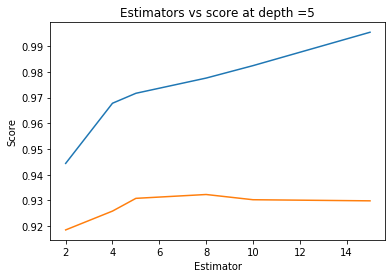

In [51]:
import xgboost 
from xgboost.sklearn import XGBClassifier
est=[2,4,5,8,10,15]
train_scores=[]
test_scores=[]
for i in est:
    clf=XGBClassifier(learning_rate =0.1,n_estimators=50, max_depth=i, min_child_weight=1, gamma=0,subsample=0.8,
                      colsample_bytree=0.8, objective= 'binary:logistic',nthread=-1, scale_pos_weight=1,seed=27)
    clf.fit(df_train_final,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train_final))
    test_sc = f1_score(y_test,clf.predict(df_test_final))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('estimators',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(est,train_scores,label='Train Score')
plt.plot(est,test_scores,label='Test Score')
plt.xlabel('Estimator')
plt.ylabel('Score')
plt.title('Estimators vs score at depth =5')
plt.show()

In [10]:
import xgboost 
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV 
param_dist={'max_depth':sp_randint(3,10),
            'n_estimators':sp_randint(45,65),
            }
clf=XGBClassifier(min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8, 
                  learning_rate =0.1,objective= 'binary:logistic',nthread=-1, scale_pos_weight=1,seed=27)
    
cv_search=cv_search=RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, scoring='f1', n_jobs=-1, 
                             cv=10,random_state=23,return_train_score=True)
cv_search.fit(df_train_final,y_train)
print('mean test scores',cv_search.cv_results_['mean_test_score'])
print('mean train scores',cv_search.cv_results_['mean_train_score'])

mean test scores [0.97325538 0.96758611 0.97656612 0.97571552 0.9733577 ]
mean train scores [0.97383067 0.96744993 0.98006596 0.97781572 0.97394312]


In [11]:
cv_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [12]:
from sklearn.model_selection import GridSearchCV 
param_dist={
            'learning_rate':[0.02,0.01,0.1,0.2,0.3]
            }
clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)
    
cv_search=cv_search=RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, scoring='f1', n_jobs=-1, 
                             cv=10,random_state=23,return_train_score=True)
cv_search.fit(df_train_final,y_train)
print('mean test scores',cv_search.cv_results_['mean_test_score'])
print('mean train scores',cv_search.cv_results_['mean_train_score'])

mean test scores [0.97330056 0.97255065 0.97656612 0.97912255 0.98061909]
mean train scores [0.97588344 0.97485085 0.98006596 0.98973018 0.99732628]


In [13]:
cv_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [14]:
from sklearn.model_selection import GridSearchCV 
param_dist={
            'reg_alpha':[1e-5, 1e-2,0, 0.1, 1, 100],
    'reg_lambda':[1e-5, 1e-2,0, 0.1, 1, 100]
            }
clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              scale_pos_weight=1, seed=27,silent=None, subsample=0.8, verbosity=1)
    
cv_search=cv_search=RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, scoring='f1', n_jobs=-1, 
                             cv=10,random_state=23,return_train_score=True)
cv_search.fit(df_train_final,y_train)
print('mean test scores',cv_search.cv_results_['mean_test_score'])
print('mean train scores',cv_search.cv_results_['mean_train_score'])

mean test scores [0.97994321 0.97776425 0.98033615 0.97436467 0.9801743 ]
mean train scores [0.99769433 0.98339259 0.99747425 0.97547856 0.99785023]


In [15]:
cv_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [17]:
from sklearn.model_selection import GridSearchCV 
param_dist={
            'subsample':[i/10.0 for i in range(6,10)],
             'colsample_bytree':[i/10.0 for i in range(6,10)]
             }
clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)
    
cv_search=cv_search=RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, scoring='f1', n_jobs=-1, 
                             cv=10,random_state=23,return_train_score=True)
cv_search.fit(df_train_final,y_train)
print('mean test scores',cv_search.cv_results_['mean_test_score'])
print('mean train scores',cv_search.cv_results_['mean_train_score'])

mean test scores [0.97909887 0.9804474  0.98026422 0.9798136  0.97950494]
mean train scores [0.99640018 0.99730133 0.99659207 0.99685842 0.99666833]


In [18]:
cv_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

In [19]:
clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=53, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)
    

clf.fit(df_train_final,y_train)
y_train_predict=clf.predict(df_train_final)
y_test_predict=clf.predict(df_test_final)

In [20]:
print('f1 score of train data is',f1_score(y_train,y_train_predict))
print('f1 score of train data is',f1_score(y_test,y_test_predict))

f1 score of train data is 0.9971591477443235
f1 score of train data is 0.9259518804017753


Train confusion_matrix


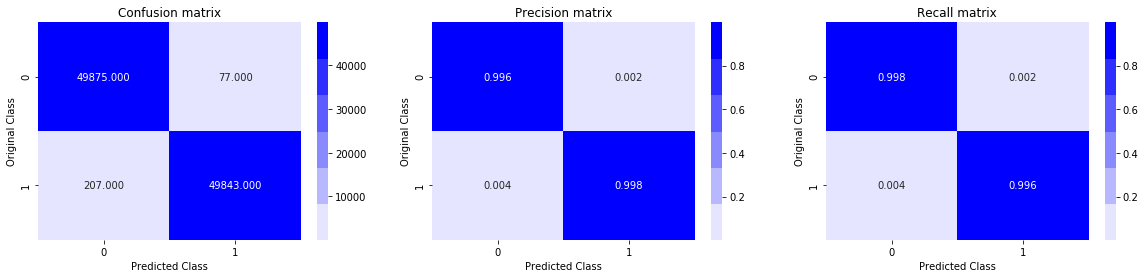

Test confusion_matrix


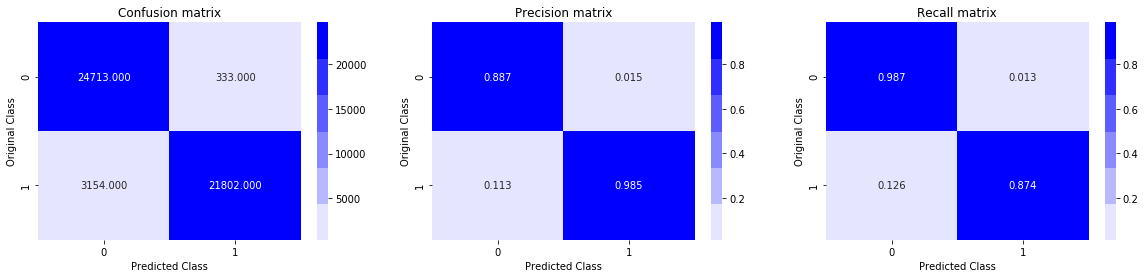

In [22]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_predict)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_predict)

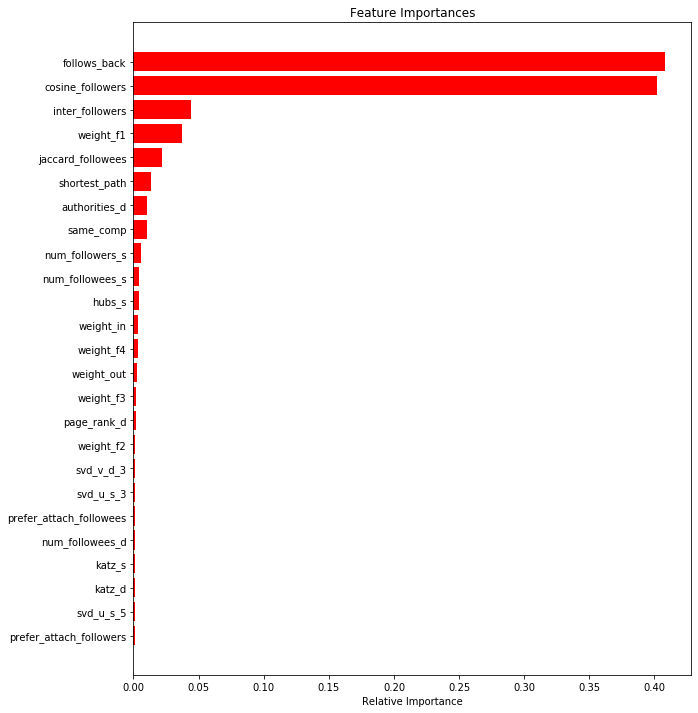

In [23]:
features=df_train_final.columns
imp=clf.feature_importances_
indices = (np.argsort(imp))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()